In [ ]:
# Cell 1: Installation
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 1.02 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 1.41s
 Downloaded cuproj-cu12
 Downloaded cudf-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded rmm-cu12
 Downloaded dask
 Downloaded ucx-py-cu12
 Downloaded libkvikio-cu12
 Downloaded pylibcugraph-cu12
 Downloaded cugraph-cu12
 Downloaded cuspatial-cu12
 Downloaded bokeh
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded libcudf-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcuvs

In [ ]:
!pip install dask dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 19.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # Corrected import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
# --- Load Data from Excel File ---
# IMPORTANT: Replace 'your_student_grades.xlsx' with the actual path to your file.
excel_file_path = 'data_grades_exams_PaS24_English.xlsx' # <--- CHANGE THIS TO YOUR FILE PATH

try:
    # Attempt to read the Excel file
    # Specify the sheet name if it's not the first one, e.g., sheet_name='Sheet1'
    df = pd.read_excel(excel_file_path)
    print(f"Successfully loaded data from '{excel_file_path}'.")
    print("Shape of the loaded data:", df.shape)
    print("First 5 rows:\n", df.head())


except FileNotFoundError:
    print(f"\n--- ERROR ---")
    print(f"The file '{excel_file_path}' was not found.")
    print("Please make sure the file path is correct and the file exists in that location.")
    # Assign empty structures to prevent later cells from failing immediately
    X = pd.DataFrame()
    y_continuous = pd.Series()
    df = pd.DataFrame() # Define df as empty
except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"An error occurred while reading the Excel file: {e}")
    # Assign empty structures
    X = pd.DataFrame()
    y_continuous = pd.Series()
    df = pd.DataFrame() # Define df as empty


Successfully loaded data from 'data_grades_exams_PaS24_English.xlsx'.
Shape of the loaded data: (262, 19)
First 5 rows:
    #  PAS_final  PAS_mid  PAS_score PAS_grade  EM_final  EM_mid  EM_score  \
0  1       33.0     17.5  56.410000        B+         2     2.0      30.4   
1  2       21.0      0.0  24.121538        D0         0     1.0       6.0   
2  3       32.0      3.0  62.525385        A0        13    14.0      49.0   
3  4       23.4      3.5  32.848462        D+         0     4.0      12.5   
4  5       26.2      7.0  56.084615        B+        14    10.0      39.5   

  EM_grade  LA_final  LA_mid  LA_score LA_grade  DM_final  DM_mid  DM_score  \
0       C0         0       7     22.07       D0         0       4     10.90   
1        F         1       3     27.50        F         5       4     21.89   
2       B0        31      11     64.67       B+        32      10     59.86   
3        F         2       4     18.03       D0         9       8     25.21   
4       C+        14 

In [ ]:
prefixes = ["EM","DM","LA","PAS"]
for prefix in prefixes:
    df[f"{prefix}_etc_score"] = df[f"{prefix}_score"] - (df[f"{prefix}_mid"]+df[f"{prefix}_final"])
df.head()

,#,PAS_final,PAS_mid,PAS_score,PAS_grade,EM_final,EM_mid,EM_score,EM_grade,LA_final,...,DM_final,DM_mid,DM_score,DM_grade,AE1_grade,AE2_grade,EM_etc_score,DM_etc_score,LA_etc_score,PAS_etc_score
0,1,33.0,17.5,56.410000,B+,2,2.0,30.4,C0,0,...,0,4,10.90,F,B+,B+,26.4,6.90,15.07,5.910000
1,2,21.0,0.0,24.121538,D0,0,1.0,6.0,F,1,...,5,4,21.89,D+,D+,D+,5.0,12.89,23.50,3.121538
2,3,32.0,3.0,62.525385,A0,13,14.0,49.0,B0,31,...,32,10,59.86,B+,B+,B+,22.0,17.86,22.67,27.525385
3,4,23.4,3.5,32.848462,D+,0,4.0,12.5,F,2,...,9,8,25.21,C0,C+,D+,8.5,8.21,12.03,5.948462
4,5,26.2,7.0,56.084615,B+,14,10.0,39.5,C+,14,...,15,15,41.47,B0,A0,A+,15.5,11.47,23.43,22.884615


In [ ]:
# Calculate and visualize correlation in one line
df_etc_scores = df[["EM_etc_score", "DM_etc_score", "LA_etc_score", "PAS_etc_score"]]
df_etc_scores.corr().style.background_gradient(cmap="Blues")



#df.corr().style.background_gradient(cmap="Blues")


,EM_etc_score,DM_etc_score,LA_etc_score,PAS_etc_score
EM_etc_score,1.000000,0.669246,0.684390,0.624700
DM_etc_score,0.669246,1.000000,0.692469,0.652572
LA_etc_score,0.684390,0.692469,1.000000,0.664276
PAS_etc_score,0.624700,0.652572,0.664276,1.000000


In [ ]:
df_mid_scores = df[["EM_mid", "DM_mid", "LA_mid", "PAS_mid"]]
df_mid_scores.corr().style.background_gradient(cmap="Blues")

,EM_mid,DM_mid,LA_mid,PAS_mid
EM_mid,1.000000,0.672574,0.762442,0.674370
DM_mid,0.672574,1.000000,0.721400,0.706243
LA_mid,0.762442,0.721400,1.000000,0.705053
PAS_mid,0.674370,0.706243,0.705053,1.000000


In [ ]:
df_final_scores = df[["EM_final", "DM_final", "LA_final", "PAS_final"]]
df_final_scores.corr().style.background_gradient(cmap="Blues")

,EM_final,DM_final,LA_final,PAS_final
EM_final,1.000000,0.678732,0.747366,0.316970
DM_final,0.678732,1.000000,0.716312,0.329912
LA_final,0.747366,0.716312,1.000000,0.278257
PAS_final,0.316970,0.329912,0.278257,1.000000


In [ ]:
df_mid_and_final_scores = df[["EM_mid", "EM_final", "DM_mid", "DM_final", "LA_mid", "LA_final", "PAS_mid", "PAS_final"]]
df_mid_and_final_scores.corr().style.background_gradient(cmap="Blues")

,EM_mid,EM_final,DM_mid,DM_final,LA_mid,LA_final,PAS_mid,PAS_final
EM_mid,1.000000,0.747469,0.672574,0.673976,0.762442,0.742309,0.674370,0.228360
EM_final,0.747469,1.000000,0.672981,0.678732,0.717755,0.747366,0.647516,0.316970
DM_mid,0.672574,0.672981,1.000000,0.765967,0.721400,0.692976,0.706243,0.280980
DM_final,0.673976,0.678732,0.765967,1.000000,0.687407,0.716312,0.649632,0.329912
LA_mid,0.762442,0.717755,0.721400,0.687407,1.000000,0.763378,0.705053,0.268914
LA_final,0.742309,0.747366,0.692976,0.716312,0.763378,1.000000,0.654768,0.278257
PAS_mid,0.674370,0.647516,0.706243,0.649632,0.705053,0.654768,1.000000,0.309427
PAS_final,0.228360,0.316970,0.280980,0.329912,0.268914,0.278257,0.309427,1.000000


In [ ]:
df_total_scores = df[["EM_score", "DM_score", "LA_score", "PAS_score"]]
df_total_scores.corr().style.background_gradient(cmap="Blues")

,EM_score,DM_score,LA_score,PAS_score
EM_score,1.000000,0.812302,0.861852,0.675472
DM_score,0.812302,1.000000,0.822225,0.695424
LA_score,0.861852,0.822225,1.000000,0.672340
PAS_score,0.675472,0.695424,0.672340,1.000000


In [ ]:
df_total_scores_capped = df[["EM_score", "DM_score", "LA_score", "PAS_score"]].copy()
for prefix in prefixes:
    df_total_scores_capped[f"{prefix}_score_capped"] = df_total_scores_capped[f"{prefix}_score"].apply(lambda x: 100 if x > 100 else x)

df_total_scores_capped.drop(columns=["PAS_score","EM_score", "DM_score", "LA_score"], inplace=True)
df_total_scores_capped.corr().style.background_gradient(cmap="Blues")

,EM_score_capped,DM_score_capped,LA_score_capped,PAS_score_capped
EM_score_capped,1.000000,0.813810,0.865253,0.661734
DM_score_capped,0.813810,1.000000,0.821096,0.696988
LA_score_capped,0.865253,0.821096,1.000000,0.671849
PAS_score_capped,0.661734,0.696988,0.671849,1.000000


# consider working with this

In [ ]:
df_total_scores_minus_final = df[["EM_score", "DM_score", "LA_score", "PAS_score"]].copy()
for prefix in prefixes:
    df_total_scores_minus_final[f"{prefix}_score_minus_final"] = df_total_scores_minus_final[f"{prefix}_score"] - df[f"{prefix}_final"]

df_total_scores_minus_final["math_avg"]= (df_total_scores_minus_final["EM_score"]+df_total_scores_minus_final["DM_score"]+df_total_scores_minus_final["LA_score"])/3
#df_total_scores_minus_final.drop(columns=["PAS_score","EM_score", "DM_score", "LA_score"], inplace=True)
df_total_scores_minus_final.corr().style.background_gradient(cmap="Blues")

,EM_score,DM_score,LA_score,PAS_score,EM_score_minus_final,DM_score_minus_final,LA_score_minus_final,PAS_score_minus_final,math_avg
EM_score,1.000000,0.812302,0.861852,0.675472,0.965918,0.788890,0.817445,0.701359,0.946472
DM_score,0.812302,1.000000,0.822225,0.695424,0.793837,0.948407,0.774249,0.734666,0.929160
LA_score,0.861852,0.822225,1.000000,0.672340,0.830985,0.801666,0.924016,0.702120,0.951425
PAS_score,0.675472,0.695424,0.672340,1.000000,0.683294,0.721216,0.712156,0.918074,0.722212
EM_score_minus_final,0.965918,0.793837,0.830985,0.683294,1.000000,0.783278,0.814998,0.712383,0.916801
DM_score_minus_final,0.788890,0.948407,0.801666,0.721216,0.783278,1.000000,0.792523,0.776463,0.895790
LA_score_minus_final,0.817445,0.774249,0.924016,0.712156,0.814998,0.792523,1.000000,0.739380,0.891539
PAS_score_minus_final,0.701359,0.734666,0.702120,0.918074,0.712383,0.776463,0.739380,1.000000,0.755639
math_avg,0.946472,0.929160,0.951425,0.722212,0.916801,0.895790,0.891539,0.755639,1.000000


In [ ]:
df_total_scores_minus_final_capped = df_total_scores_capped.copy()
for prefix in prefixes:
    df_total_scores_minus_final_capped[f"{prefix}_score_minus_final_capped"] = df_total_scores_minus_final_capped[f"{prefix}_score_capped"] - df[f"{prefix}_final"]

df_total_scores_minus_final_capped.drop(columns=["PAS_score_capped","EM_score_capped", "DM_score_capped", "LA_score_capped"], inplace=True)
df_total_scores_minus_final_capped.corr().style.background_gradient(cmap="Blues")

NameError: name 'df_total_scores_capped' is not defined

# ranking with unweighted

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_total_minus_final_scaled = scaler.fit_transform(df_total_scores_minus_final)
df_total_minus_final_scaled = pd.DataFrame(df_total_minus_final_scaled, columns=df_total_scores_minus_final.columns)
print(df_total_minus_final_scaled.head())
# Best feature set based on research
target_col = "PAS_score_minus_final"
best_features = []
for prefix in prefixes:

    if prefix == "PAS":
      continue
    score_min_fin = f"{prefix}_score_minus_final"
    best_features.append(score_min_fin)
    mid_col = f'{prefix}_mid'
    final_col = f'{prefix}_final'

    # Define the names for the new percentile rank columns
    mid_pct_col = f'{prefix}_mid_pct_rank'
    final_pct_col = f'{prefix}_final_pct_rank'

    # Calculate the percentile rank for midterm and final scores
    df_total_minus_final_scaled[mid_pct_col] = df[mid_col].rank(pct=True)
    df_total_minus_final_scaled[final_pct_col] = df[final_col].rank(pct=True)
    best_features.append(f"{prefix}_mid_pct_rank")
    best_features.append(f"{prefix}_final_pct_rank")

print(best_features)

X = df_total_minus_final_scaled[best_features].values
y = df_total_minus_final_scaled[target_col].values



print(df_total_minus_final_scaled.head())

   EM_score  DM_score  LA_score  PAS_score  EM_score_minus_final  \
0  0.239370  0.111304  0.179470   0.420970              0.319101   
1  0.047244  0.223527  0.232809   0.180011              0.067416   
2  0.385827  0.611253  0.597937   0.466607              0.404494   
3  0.098425  0.257429  0.139784   0.245138              0.140449   
4  0.311024  0.423466  0.467878   0.418542              0.286517   

   DM_score_minus_final  LA_score_minus_final  PAS_score_minus_final  \
0              0.188158              0.305082               0.242591   
1              0.291559              0.373100               0.032348   
2              0.480925              0.483187               0.316325   
3              0.279820              0.212345               0.097912   
4              0.456931              0.540918               0.309685   

   math_avg  EM_mid_pct_rank  EM_final_pct_rank  DM_mid_pct_rank  \
0  0.184319         0.146640           0.080321         0.068898   
1  0.159490         0.

# thaaat's what you neeed!!!!

In [ ]:
df_weighted_mid_and_etc = df[['EM_final','LA_final','DM_final',"EM_mid", "EM_etc_score", "DM_mid", "DM_etc_score", "LA_mid", "LA_etc_score", "PAS_mid", "PAS_etc_score"]].copy()
for prefix in prefixes:
    df_weighted_mid_and_etc[f"{prefix}_mid_and_etc_w"] = 2*df_weighted_mid_and_etc[f"{prefix}_mid"] + df_weighted_mid_and_etc[f"{prefix}_etc_score"]
df_weighted_mid_and_etc.corr().style.background_gradient(cmap="Blues")


,EM_final,LA_final,DM_final,EM_mid,EM_etc_score,DM_mid,DM_etc_score,LA_mid,LA_etc_score,PAS_mid,PAS_etc_score,EM_mid_and_etc_w,DM_mid_and_etc_w,LA_mid_and_etc_w,PAS_mid_and_etc_w
EM_final,1.000000,0.747366,0.678732,0.747469,0.558701,0.672981,0.545597,0.717755,0.473370,0.647516,0.392098,0.791715,0.693075,0.733867,0.630887
LA_final,0.747366,1.000000,0.716312,0.742309,0.488933,0.692976,0.537950,0.763378,0.439284,0.654768,0.355182,0.758513,0.705203,0.754832,0.617479
DM_final,0.678732,0.716312,1.000000,0.673976,0.534041,0.765967,0.624828,0.687407,0.437678,0.649632,0.420551,0.726611,0.790201,0.696564,0.646415
EM_mid,0.747469,0.742309,0.673976,1.000000,0.428269,0.672574,0.516604,0.762442,0.387596,0.674370,0.300751,0.924878,0.682488,0.733436,0.603717
EM_etc_score,0.558701,0.488933,0.534041,0.428269,1.000000,0.521899,0.669246,0.503725,0.684390,0.497269,0.624700,0.739723,0.624798,0.655973,0.644875
DM_mid,0.672981,0.692976,0.765967,0.672574,0.521899,1.000000,0.613728,0.721400,0.437364,0.706243,0.476887,0.720458,0.959976,0.722223,0.712503
DM_etc_score,0.545597,0.537950,0.624828,0.516604,0.669246,0.613728,1.000000,0.568718,0.692469,0.589314,0.652572,0.666318,0.810294,0.708504,0.720745
LA_mid,0.717755,0.763378,0.687407,0.762442,0.503725,0.721400,0.568718,1.000000,0.435674,0.705053,0.349213,0.779731,0.737216,0.932868,0.648423
LA_etc_score,0.473370,0.439284,0.437678,0.387596,0.684390,0.437364,0.692469,0.435674,1.000000,0.451702,0.664276,0.576624,0.570290,0.730661,0.633769
PAS_mid,0.647516,0.654768,0.649632,0.674370,0.497269,0.706243,0.589314,0.705053,0.451702,1.000000,0.448623,0.711431,0.733272,0.715561,0.896544


# rancking added

In [ ]:
# List of subject prefixes
subjects = ['EM', 'DM', 'LA']

# Loop through each subject to create the new percentile rank features
for subject in subjects:
    mid_col = f'{subject}_mid'
    final_col = f'{subject}_final'

    # Define the names for the new percentile rank columns
    mid_pct_col = f'{subject}_mid_pct_rank'
    final_pct_col = f'{subject}_final_pct_rank'

    # Calculate the percentile rank for midterm and final scores
    df_weighted_mid_and_etc[mid_pct_col] = df_weighted_mid_and_etc[mid_col].rank(pct=True)
    df_weighted_mid_and_etc[final_pct_col] = df_weighted_mid_and_etc[final_col].rank(pct=True)

# Display the result to see the new columns
print("DataFrame with new Percentile Rank columns:")
# Showing original scores alongside the new rank columns for comparison
display_cols = [
    'EM_mid', 'EM_mid_pct_rank',
    'EM_final', 'EM_final_pct_rank',
    'DM_mid', 'DM_mid_pct_rank'
]
print(df_weighted_mid_and_etc[display_cols].head())

# Let's sort by one of the columns to verify the ranks
print("\nTop 5 students in EM Midterm, showing their percentile rank:")
print(df_weighted_mid_and_etc.sort_values('EM_mid', ascending=False)[display_cols].head())

DataFrame with new Percentile Rank columns:
   EM_mid  EM_mid_pct_rank  EM_final  EM_final_pct_rank  DM_mid  \
0     2.0         0.196565         2           0.124046       4   
1     1.0         0.143130         0           0.047710       4   
2    14.0         0.692748        13           0.564885      10   
3     4.0         0.320611         0           0.047710       8   
4    10.0         0.591603        14           0.606870      15   

   DM_mid_pct_rank  
0         0.095420  
1         0.095420  
2         0.387405  
3         0.286260  
4         0.612595  

Top 5 students in EM Midterm, showing their percentile rank:
     EM_mid  EM_mid_pct_rank  EM_final  EM_final_pct_rank  DM_mid  \
64     30.0         0.996183        29           0.898855      28   
103    30.0         0.996183        39           0.998092      18   
149    30.0         0.996183        38           0.986641      30   
237    29.0         0.971374        37           0.975191      26   
114    29.0         

In [ ]:
df_scaled = df_total_scores_minus_final.copy()


# Best feature set based on research
target_col = "PAS_mid_and_etc_w"
best_features = []
for prefix in prefixes:
    if prefix == "PAS":
      continue
    #best_features.append(f"{prefix}_score_minus_final")
    best_features.append(f"{prefix}_mid_and_etc_w")
    best_features.append(f"{prefix}_final_pct_rank")
    best_features.append(f"{prefix}_mid_pct_rank")
#best_features.append("math_avg")
#print(best_features)

X = df_weighted_mid_and_etc[best_features].values
y = df_weighted_mid_and_etc[target_col].values

print("Features used for prediction:")
print(best_features)
print("\nTarget variable:")
print(target_col)
print("\nX shape:", X.shape)
print("y shape:", y.shape)

Features used for prediction:
['EM_mid_and_etc_w', 'EM_final_pct_rank', 'EM_mid_pct_rank', 'DM_mid_and_etc_w', 'DM_final_pct_rank', 'DM_mid_pct_rank', 'LA_mid_and_etc_w', 'LA_final_pct_rank', 'LA_mid_pct_rank']

Target variable:
PAS_mid_and_etc_w

X shape: (262, 9)
y shape: (262,)


In [ ]:
# Apply the complete enhancement pipeline
X_enhanced = X
y_enhanced = y
feature_names = best_features
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.linear_model import Ridge, Lasso, ElasticNet
from cuml.metrics import r2_score

# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Test the improved model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score # Import cross_val_score

def test_improved_performance(X_processed, y, feature_names):
    '''Test model performance with improved features'''

    print("\nMODEL PERFORMANCE COMPARISON")
    print("=" * 30)

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': cuRandomForestRegressor(n_estimators=100, random_state=42),
        "Gaussian Process Regression": GaussianProcessRegressor(random_state=42),
        "Ridge Regression": Ridge(random_state=42),
        "LASSO": Lasso(random_state=42),
        "Elastic Net": ElasticNet(random_state=42)
    }

    for name, model in models.items():
        scores = cross_val_score(model, X_processed, y, cv=5, scoring='r2')
        print(f"{name}: R² = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

    return scores.mean()

improved_r2 = test_improved_performance(X_enhanced, y_enhanced, feature_names)


MODEL PERFORMANCE COMPARISON
Linear Regression: R² = 0.6188 (+/- 0.1739)


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recomm

Random Forest: R² = 0.5973 (+/- 0.1913)
Gaussian Process Regression: R² = -2.7799 (+/- 3.6457)
Ridge Regression: R² = 0.6246 (+/- 0.1503)
LASSO: R² = -0.0518 (+/- 0.0932)
Elastic Net: R² = -0.0518 (+/- 0.0932)


In [ ]:
import numpy as np
import cupy as cp  # Use cupy for GPU arrays
import cudf
import dask_ml.model_selection as dcv

# 1. Import cuML models directly
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.linear_model import Ridge, Lasso, ElasticNet
from cuml.metrics import r2_score


# 3. Define cuML models and their parameter grids
# Note the changes in models and parameters
models_and_parameters = [
    {
        'name': 'Random Forest',
        'model': cuRandomForestRegressor(),
        'parameters': {
            # Simplified for demonstration; many sklearn params are not in cuML
            'n_estimators': [100, 200, 500, 1000],
            'max_depth': [5,10, 20, 30]
        }
    },
    # GaussianProcessRegressor is not available in cuML and has been removed.
    {
        'name': 'Ridge Regression',
        'model': Ridge(),  # 'random_state' is not a parameter in cuML's Ridge
        'parameters': {
            'alpha': np.logspace(-3, 2, 10).tolist()
        }
    },
    {
        'name': 'LASSO',
        'model': Lasso(), # 'random_state' is not a parameter in cuML's Lasso
        'parameters': {
            'alpha': np.logspace(-3, 2, 10).tolist()
        }
    },
    {
        'name': 'Elastic Net',
        'model': ElasticNet(), # 'random_state' is not a parameter in cuML's ElasticNet
        'parameters': {
            'alpha': np.logspace(-3, 2, 10).tolist(),
            'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
        }
    }
]

tuned_models = {}

print("\nFINE-TUNING CUML MODELS WITH DASK-ML")
print("=" * 40)

for model_info in models_and_parameters:
    name = model_info['name']
    model = model_info['model']
    parameters = model_info['parameters']

    print(f"\nFine-tuning {name}...")

    # 4. Use dask_ml's GridSearchCV
    # It handles parallel execution on the GPU without pickling errors.
    # n_jobs is not required here.
    grid_search = dcv.GridSearchCV(model, parameters, cv=3, scoring='r2')

    # Perform the grid search using GPU data
    grid_search.fit(X_enhanced, y_enhanced)

    # Store the best model
    tuned_models[name] = grid_search.best_estimator_

    # Print the best parameters and best score
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best R² score for {name}: {grid_search.best_score_:.4f}")

print("\nFINE-TUNING COMPLETE")


FINE-TUNING CUML MODELS WITH DASK-ML

Fine-tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 1000}
Best R² score for Random Forest: 0.6306

Fine-tuning Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 0.5994842503189409}
Best R² score for Ridge Regression: 0.6394

Fine-tuning LASSO...
Best parameters for LASSO: {'alpha': 0.001}
Best R² score for LASSO: 0.6354

Fine-tuning Elastic Net...
Best parameters for Elastic Net: {'alpha': 0.003593813663804626, 'l1_ratio': 0.1}
Best R² score for Elastic Net: 0.6403

FINE-TUNING COMPLETE


In [ ]:
import numpy as np
import cupy as cp
import dask_ml.model_selection as dcv
import xgboost as xgb

# Import cuML models, including the new ones
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from cuml.svm import SVR
from cuml.neighbors import KNeighborsRegressor
# MBSGDRegressor is no longer available in this cuML version
# from cuml.experimental.linear_model import MBSGDRegressor
from cuml.pipeline import Pipeline
from cuml.preprocessing import MinMaxScaler


# Define the models and their parameter grids
pipelines_and_parameters = [


    # --- 5 NEW MODELS WITH LARGE PARAMETER GRIDS ---
    {
        'name': 'Linear Regression (Baseline)',
        'model': LinearRegression(),
        'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', LinearRegression())]),
        'parameters': {} # No parameters to tune
    },
    {
        'name': 'Support Vector Regressor (SVR)',
        'model':SVR(),
        'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', SVR())]),
        'parameters': {
            'model__kernel': ['rbf', 'linear'],
            'model__C': np.logspace(-2, 2, 5).tolist(), # Regularization parameter
            'model__gamma': np.logspace(-2, 2, 5).tolist(), # Kernel coefficient
            'model__epsilon': [0.01, 0.1, 0.2] # Margin of tolerance
        }
    },
    {
        'name': 'K-Nearest Neighbors (KNN)',
        'model': KNeighborsRegressor(),
        'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', KNeighborsRegressor())]),
        'parameters': {
            'model__n_neighbors': list(range(2, 21)), # Number of neighbors
            'model__weights': ['uniform'], # Only uniform is supported by cuML
            'model__p': [1, 2] # Power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
        }
    },
    # MBSGD Regressor was removed due to import error
    # {
    #     'name': 'MBSGD Regressor',
    #     'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', MBSGDRegressor(eta0=0.01))]),
    #     'parameters': {
    #         'model__loss': ['squared_loss', 'huber'],
    #         'model__penalty': ['l1', 'l2', 'elasticnet'],
    #         'model__alpha': np.logspace(-4, 0, 5).tolist(), # Regularization strength
    #         'model__learning_rate': ['constant', 'invscaling', 'adaptive']
    #     }
    # },
    {
        'name': 'XGBoost',
        'model': xgb.XGBRegressor(tree_method='gpu_hist'),
        'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', xgb.XGBRegressor(tree_method='gpu_hist'))]),
        'parameters': {
            'model__n_estimators': [50, 100, 200, 300, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7, 9],
            'model__subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of training instances
            'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Fraction of features
        }
    }
]

tuned_pipelines = {}

print("\nFINE-TUNING CUML PIPELINES WITH DASK-ML")
print("=" * 40)

for pipeline_info in pipelines_and_parameters:
    name = pipeline_info['name']
    pipeline = pipeline_info['pipeline']
    parameters = pipeline_info['parameters']

    if not parameters:
        print(f"\nTraining {name} (no parameters to tune)...")
        pipeline.fit(X_enhanced, y_enhanced)
        tuned_pipelines[name] = pipeline
        # To get a score, you'd need a separate test set. Here we just fit.
        print(f"{name} model has been fitted.")
        continue

    print(f"\nFine-tuning {name} pipeline...")
    grid_search = dcv.GridSearchCV(pipeline, parameters, cv=3, scoring='r2')
    grid_search.fit(X_enhanced, y_enhanced)
    tuned_pipelines[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best R² score for {name}: {grid_search.best_score_:.4f}")

print("\nFINE-TUNING COMPLETE")


FINE-TUNING CUML PIPELINES WITH DASK-ML

Training Linear Regression (Baseline) (no parameters to tune)...
Linear Regression (Baseline) model has been fitted.

Fine-tuning Support Vector Regressor (SVR) pipeline...
Best parameters for Support Vector Regressor (SVR): {'model__C': 100.0, 'model__epsilon': 0.1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Best R² score for Support Vector Regressor (SVR): 0.6625

Fine-tuning K-Nearest Neighbors (KNN) pipeline...
[2025-06-14 13:31:33.043] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Best parameters for K-Nearest Neighbors (KNN): {'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'uniform'}
Best R² score for K-Nearest Neighbors (KNN): 0.5955

Fine-tuning XGBoost pipeline...
Best parameters for XGBoost: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.9}
Best R² score for XGBoost: 0.6326

FINE-TUNING COMPLETE


In [ ]:
import numpy as np
import cupy as cp
import dask_ml.model_selection as dcv
import xgboost as xgb

# Import cuML models, including the new ones
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from cuml.svm import SVR
from cuml.neighbors import KNeighborsRegressor
# MBSGDRegressor is no longer available in this cuML version
# from cuml.experimental.linear_model import MBSGDRegressor
from cuml.pipeline import Pipeline
from cuml.preprocessing import MinMaxScaler


# Define the models and their parameter grids
models_and_parameters = [


    # --- 5 NEW MODELS WITH LARGE PARAMETER GRIDS ---
    {
        'name': 'Linear Regression (Baseline)',
        'model': LinearRegression(),
        'parameters': {} # No parameters to tune
    },
    {
        'name': 'Support Vector Regressor (SVR)',
        'model':SVR(),
        'parameters': {
            'kernel': ['rbf', 'linear'],
            'C': np.logspace(-2, 2, 5).tolist(), # Regularization parameter
            'gamma': np.logspace(-2, 2, 5).tolist(), # Kernel coefficient
            'epsilon': [0.01, 0.1, 0.2] # Margin of tolerance
        }
    },
    {
        'name': 'K-Nearest Neighbors (KNN)',
        'model': KNeighborsRegressor(),
        'parameters': {
            'n_neighbors': list(range(2, 21)), # Number of neighbors
            'weights': ['uniform'], # Only uniform is supported by cuML
            'p': [1, 2] # Power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
        }
    },
    # MBSGD Regressor was removed due to import error
    # {
    #     'name': 'MBSGD Regressor',
    #     'pipeline': Pipeline([('scaler', MinMaxScaler()), ('model', MBSGDRegressor(eta0=0.01))]),
    #     'parameters': {
    #         'model__loss': ['squared_loss', 'huber'],
    #         'model__penalty': ['l1', 'l2', 'elasticnet'],
    #         'model__alpha': np.logspace(-4, 0, 5).tolist(), # Regularization strength
    #         'model__learning_rate': ['constant', 'invscaling', 'adaptive']
    #     }
    # },
    {
        'name': 'XGBoost',
        'model': xgb.XGBRegressor(tree_method='gpu_hist'),
        'parameters': {
            'n_estimators': [50, 100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of training instances
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Fraction of features
        }
    }
]

tuned_models = {}

print("\nFINE-TUNING CUML MODELS WITH DASK-ML (WITHOUT PIPELINES)")
print("=" * 40)

for model_info in models_and_parameters:
    name = model_info['name']
    model = model_info['model']
    parameters = model_info['parameters']

    if not parameters:
        print(f"\nTraining {name} (no parameters to tune)...")
        model.fit(X_enhanced, y_enhanced)
        tuned_models[name] = model
        # To get a score, you'd need a separate test set. Here we just fit.
        print(f"{name} model has been fitted.")
        continue

    print(f"\nFine-tuning {name}...")
    grid_search = dcv.GridSearchCV(model, parameters, cv=3, scoring='r2')
    grid_search.fit(X_enhanced, y_enhanced)
    tuned_models[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best R² score for {name}: {grid_search.best_score_:.4f}")

print("\nFINE-TUNING COMPLETE")


FINE-TUNING CUML MODELS WITH DASK-ML (WITHOUT PIPELINES)

Training Linear Regression (Baseline) (no parameters to tune)...
Linear Regression (Baseline) model has been fitted.

Fine-tuning Support Vector Regressor (SVR)...
Best parameters for Support Vector Regressor (SVR): {'C': 100.0, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best R² score for Support Vector Regressor (SVR): 0.6633

Fine-tuning K-Nearest Neighbors (KNN)...
[2025-06-14 14:03:23.690] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Best parameters for K-Nearest Neighbors (KNN): {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best R² score for K-Nearest Neighbors (KNN): 0.6014

Fine-tuning XGBoost...
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
Best R² score for XGBoost: 0.6326

FINE-TUNING COMPLETE


In [ ]:
exam_scores = pd.DataFrame()
for prefix in prefixes:
  exam_scores[f"{prefix}_mid"] = df[f"{prefix}_mid"]
  exam_scores[f"{prefix}_final"] = df[f"{prefix}_final"]

exam_scores.head()

,EM_mid,EM_final,DM_mid,DM_final,LA_mid,LA_final,PAS_mid,PAS_final
0,2.0,2,4,0,7,0,17.5,33.0
1,1.0,0,4,5,3,1,0.0,21.0
2,14.0,13,10,32,11,31,3.0,32.0
3,4.0,0,8,9,4,2,3.5,23.4
4,10.0,14,15,15,14,14,7.0,26.2


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
exam_scores_scaled = scaler.fit_transform(exam_scores)
exam_scores_scaled = pd.DataFrame(exam_scores_scaled, columns=exam_scores.columns)
exam_scores_scaled.head()

,EM_mid,EM_final,DM_mid,DM_final,LA_mid,LA_final,PAS_mid,PAS_final
0,0.066667,0.051282,0.133333,0.000,0.233333,0.000,0.603448,0.825
1,0.033333,0.000000,0.133333,0.125,0.100000,0.025,0.000000,0.525
2,0.466667,0.333333,0.333333,0.800,0.366667,0.775,0.103448,0.800
3,0.133333,0.000000,0.266667,0.225,0.133333,0.050,0.120690,0.585
4,0.333333,0.358974,0.500000,0.375,0.466667,0.350,0.241379,0.655


In [ ]:
exam_diffs = exam_scores_scaled.copy()
for prefix in prefixes:
  exam_diffs[f"{prefix}_diff"] = exam_scores_scaled[f"{prefix}_final"] - exam_scores_scaled[f"{prefix}_mid"]

exam_diffs.head()

,EM_mid,EM_final,DM_mid,DM_final,LA_mid,LA_final,PAS_mid,PAS_final,EM_diff,DM_diff,LA_diff,PAS_diff
0,0.066667,0.051282,0.133333,0.000,0.233333,0.000,0.603448,0.825,-0.015385,-0.133333,-0.233333,0.221552
1,0.033333,0.000000,0.133333,0.125,0.100000,0.025,0.000000,0.525,-0.033333,-0.008333,-0.075000,0.525000
2,0.466667,0.333333,0.333333,0.800,0.366667,0.775,0.103448,0.800,-0.133333,0.466667,0.408333,0.696552
3,0.133333,0.000000,0.266667,0.225,0.133333,0.050,0.120690,0.585,-0.133333,-0.041667,-0.083333,0.464310
4,0.333333,0.358974,0.500000,0.375,0.466667,0.350,0.241379,0.655,0.025641,-0.125000,-0.116667,0.413621


In [ ]:
# prompt: Using dataframe exam_diffs: suggest a plot for difference columns

import altair as alt

# Melt the dataframe to long format for easier plotting
melted_df = exam_diffs.melt(value_vars=['EM_diff', 'DM_diff', 'LA_diff'],
                            var_name='Exam Type',
                            value_name='Difference')

# Create a histogram to visualize the distribution of differences for each exam type
chart = alt.Chart(melted_df).mark_bar().encode(
    # Bin the 'Difference' column for the x-axis
    x=alt.X('Difference', bin=True),
    # Count the number of occurrences in each bin for the y-axis
    y='count()',
    # Color the bars based on the 'Exam Type'
    color='Exam Type'
).properties(
    # Set the title of the chart
    title='Distribution of Differences by Exam Type'
)

# Display the chart
chart

alt.Chart(...)

In [ ]:
# prompt: Using dataframe exam_diffs: suggest a plot for difference columns

import altair as alt

# Melt the dataframe to long format for easier plotting
melted_df = exam_diffs.melt(value_vars=['EM_diff', 'DM_diff', 'LA_diff','PAS_diff'],
                            var_name='Exam Type',
                            value_name='Difference')

# Create a histogram to visualize the distribution of differences for each exam type
chart = alt.Chart(melted_df).mark_bar().encode(
    # Bin the 'Difference' column for the x-axis
    x=alt.X('Difference', bin=True),
    # Count the number of occurrences in each bin for the y-axis
    y='count()',
    # Color the bars based on the 'Exam Type'
    color='Exam Type'
).properties(
    # Set the title of the chart
    title='Distribution of Differences by Exam Type'
)

# Display the chart
chart

alt.Chart(...)

In [ ]:
diff_cols = [col for col in exam_diffs.columns if col.endswith('_diff')]
print("Columns selected for analysis:")
print(diff_cols)



Columns selected for analysis:
['EM_diff', 'DM_diff', 'LA_diff', 'PAS_diff']


In [ ]:
print("\n--- Descriptive Statistics for Each Subject's Difference ---")
# Transposing (.T) makes the table easier to read
stats_per_subject = exam_diffs[diff_cols].describe().T
print(stats_per_subject)


--- Descriptive Statistics for Each Subject's Difference ---
          count      mean       std       min       25%           50%  \
EM_diff   262.0 -0.010389  0.203968 -0.800000 -0.101923  0.000000e+00   
DM_diff   262.0 -0.016190  0.194360 -0.566667 -0.150000 -1.666667e-02   
LA_diff   262.0  0.023155  0.224001 -0.566667 -0.116667  2.775558e-17   
PAS_diff  262.0  0.331028  0.287789 -0.655172  0.104741  3.668103e-01   

               75%       max  
EM_diff   0.091667  1.000000  
DM_diff   0.116667  0.600000  
LA_diff   0.175000  0.625000  
PAS_diff  0.565474  0.828017  


In [ ]:
summary_data = {}
for col in diff_cols:
    improved = (exam_diffs[col] > 0).sum()
    declined = (exam_diffs[col] < 0).sum()
    no_change = (exam_diffs[col] == 0).sum()
    summary_data[col.replace('_diff', '')] = {
        'Improved': improved,
        'Declined': declined,
        'No Change': no_change
    }

# Create a clean DataFrame from the summary dictionary
improvement_counts = pd.DataFrame(summary_data).T # Transpose for readability

print("\n--- Count of Students by Performance Change ---")
print(improvement_counts)


--- Count of Students by Performance Change ---
     Improved  Declined  No Change
EM        125       128          9
DM        116       137          9
LA        131       124          7
PAS       223        32          7


In [ ]:
# Calculate the average difference for each student (row-wise)
exam_diffs['overall_avg_diff'] = exam_diffs[diff_cols].mean(axis=1)

# Find the student who improved the most and declined the most overall
student_most_improved = exam_diffs['overall_avg_diff'].idxmax()
student_most_declined = exam_diffs['overall_avg_diff'].idxmin()

print("\n--- Overall Student Performance Analysis ---")
print(f"Student index {student_most_improved} had the highest average improvement.")
print(f"Student index {student_most_declined} had the largest average decline.")

# Display the overall difference score for context
print("\nDataFrame with Overall Average Difference:")
print(exam_diffs[['EM_diff', 'DM_diff', 'LA_diff', 'overall_avg_diff']].round(4))
stats_per_subject = exam_diffs[['EM_diff', 'DM_diff', 'LA_diff', 'overall_avg_diff']].describe().T
print(stats_per_subject)


--- Overall Student Performance Analysis ---
Student index 2 had the highest average improvement.
Student index 82 had the largest average decline.

DataFrame with Overall Average Difference:
     EM_diff  DM_diff  LA_diff  overall_avg_diff
0    -0.0154  -0.1333  -0.2333           -0.0401
1    -0.0333  -0.0083  -0.0750            0.1021
2    -0.1333   0.4667   0.4083            0.3596
3    -0.1333  -0.0417  -0.0833            0.0515
4     0.0256  -0.1250  -0.1167            0.0494
..       ...      ...      ...               ...
257  -0.3385  -0.0417   0.1250           -0.2276
258   0.3000  -0.1083  -0.2583            0.1884
259  -0.0667   0.1417   0.0750            0.0958
260  -0.1000  -0.0417  -0.2500            0.0560
261  -0.0667  -0.0500   0.0250            0.0474

[262 rows x 4 columns]
                  count      mean       std       min       25%           50%  \
EM_diff           262.0 -0.010389  0.203968 -0.800000 -0.101923  0.000000e+00   
DM_diff           262.0 -0.016190

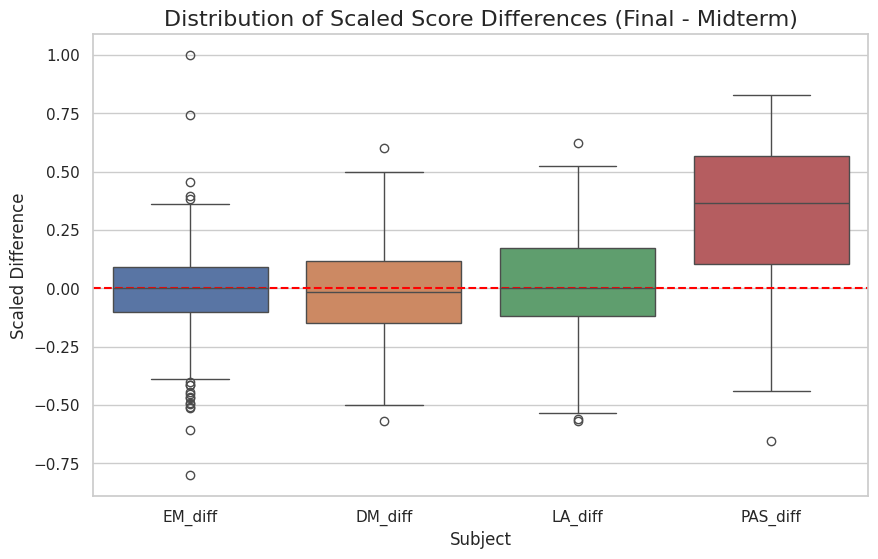

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot to visualize the distribution of differences
sns.boxplot(data=exam_diffs[diff_cols])

# Add a horizontal line at y=0 to clearly separate improvement from decline
plt.axhline(0, color='red', linestyle='--')

plt.title('Distribution of Scaled Score Differences (Final - Midterm)', fontsize=16)
plt.ylabel('Scaled Difference')
plt.xlabel('Subject')
plt.show()

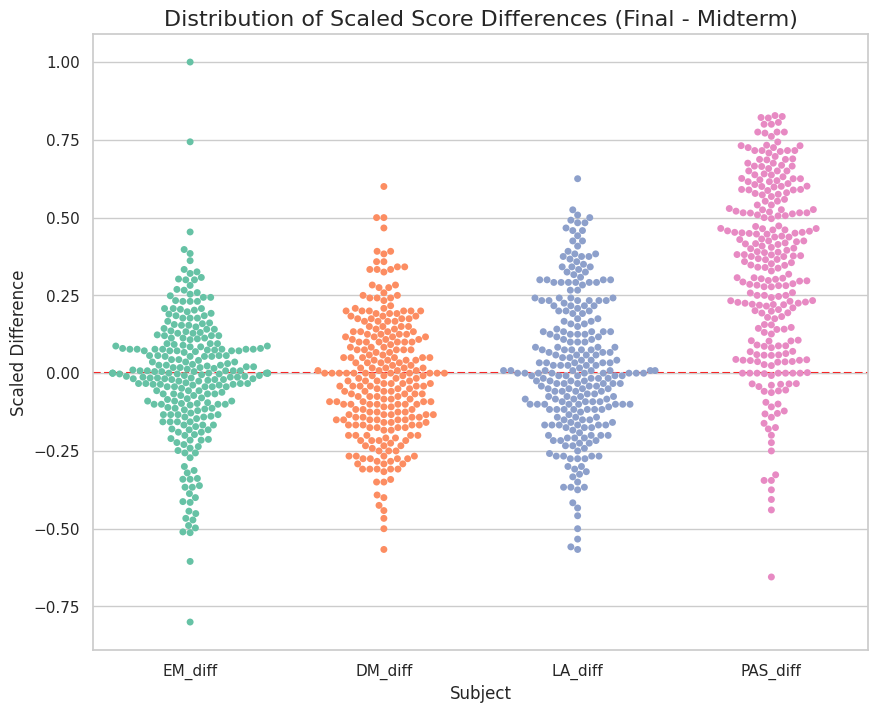

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Set plot style
sns.set_theme(style="whitegrid") # Using a modern seaborn theme
plt.figure(figsize=(10, 8))

# --- The single line to create the swarm plot ---
# We are only calling sns.swarmplot() and not sns.boxplot()
# The 'palette' argument provides distinct colors for each category.
sns.swarmplot(data=exam_diffs[diff_cols], palette="Set2", size=5)

# Add a horizontal line at y=0 to clearly separate improvement from decline
plt.axhline(0, color='red', linestyle='--', zorder=0) # zorder=0 places it behind the data points

# Add titles and labels for clarity
plt.title('Distribution of Scaled Score Differences (Final - Midterm)', fontsize=16)
plt.ylabel('Scaled Difference', fontsize=12)
plt.xlabel('Subject', fontsize=12)

# Display the plot
plt.show()

In [ ]:
from cuml.linear_model import LinearRegression

# 1. Prepare the training data from reliable subjects
# We stack the columns to create a single long list of midterms and finals
mid_scores_train = pd.concat([exam_diffs['EM_mid'], exam_diffs['DM_mid'], exam_diffs['LA_mid']], ignore_index=True)
final_scores_train = pd.concat([exam_diffs['EM_final'], exam_diffs['DM_final'], exam_diffs['LA_final']], ignore_index=True)

# The model needs X to be a 2D array, so we reshape it
X_train = mid_scores_train.values.reshape(-1, 1)
y_train = final_scores_train.values

# 2. Train the model
imputation_model = LinearRegression()
imputation_model.fit(X_train, y_train)
# --- NEW: Evaluate the Imputation Model ---
# Use the model to predict on the training data itself to see how well it fits
y_train_pred = imputation_model.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("--- Imputation Model Evaluation (Midterm vs. Final) ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("\nInterpretation:")
if r2 > 0.7:
    print(f"An R² of {r2:.2f} is strong. It means the midterm score is a good predictor of the final score.")
    print("This gives us confidence in the synthetic scores we are about to create for PAS.")
elif r2 > 0.4:
    print(f"An R² of {r2:.2f} shows a moderate relationship. The model captures some of the trend, but a lot of variance remains.")
else:
    print(f"An R² of {r2:.2f} is low. The midterm score is not a strong predictor of the final score on its own.")
    print("The synthetic scores should be used with caution.")
print("------------------------------------------------------\n")


# 3. Predict the synthetic PAS final score
pas_mid_scores = exam_scores_scaled['PAS_mid'].values.reshape(-1, 1)
predicted_pas_final = imputation_model.predict(pas_mid_scores)

# Add it to the DataFrame, clipping to ensure it's in the [0, 1] range
exam_scores_scaled['PAS_final_synthetic'] = np.clip(predicted_pas_final, 0, 1)

# Display the head of the DataFrame with the new synthetic score
print("DataFrame with the new 'PAS_final_synthetic' column:")
print(exam_scores_scaled[['PAS_mid', 'PAS_final_synthetic']].head())

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:215: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


--- Imputation Model Evaluation (Midterm vs. Final) ---
R-squared (R²): 0.5646
Root Mean Squared Error (RMSE): 0.2025

Interpretation:
An R² of 0.56 shows a moderate relationship. The model captures some of the trend, but a lot of variance remains.
------------------------------------------------------

DataFrame with the new 'PAS_final_synthetic' column:
    PAS_mid  PAS_final_synthetic
0  0.603448             0.567685
1  0.000000             0.068066
2  0.103448             0.153715
3  0.120690             0.167990
4  0.241379             0.267914


In [ ]:
y_true = pd.concat([
    exam_scores_scaled['EM_final'],
    exam_scores_scaled['DM_final'],
    exam_scores_scaled['LA_final']
], ignore_index=True)

print(exam_scores_scaled.head())
# --- Method 1: The Predictive Approach (Linear Regression) ---
print("--- Evaluating Method 1: Linear Regression Model ---")

# Prepare training data by stacking all reliable subjects
X_train_lr = pd.concat([exam_scores_scaled['EM_mid'], exam_scores_scaled['DM_mid'], exam_scores_scaled['LA_mid']], ignore_index=True).values.reshape(-1, 1)
y_train_lr = y_true # Same as our ground truth

# Train the model
imputation_model = LinearRegression()
imputation_model.fit(X_train_lr, y_train_lr)

# "Re-predict" the final scores to see how well the model fits the data
y_pred_lr = imputation_model.predict(X_train_lr)

# Calculate metrics for this method
r2_lr = r2_score(y_true, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))

print(f"R-squared (R²): {r2_lr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}\n")


# --- Method 2: The Student's Overall Average Difference ---
print("--- Evaluating Method 2: Student's Average Difference ---")

# First, calculate the difference for each subject
exam_scores_scaled['EM_diff'] = exam_scores_scaled['EM_final'] - exam_scores_scaled['EM_mid']
exam_scores_scaled['DM_diff'] = exam_scores_scaled['DM_final'] - exam_scores_scaled['DM_mid']
exam_scores_scaled['LA_diff'] = exam_scores_scaled['LA_final'] - exam_scores_scaled['LA_mid']

# Calculate each student's personal average difference across ALL reliable subjects
exam_scores_scaled['student_overall_avg_diff'] = exam_scores_scaled[['EM_diff', 'DM_diff', 'LA_diff']].mean(axis=1)

# Generate predictions for each subject by adding this overall average difference
em_final_pred = (exam_scores_scaled['EM_mid'] + exam_scores_scaled['student_overall_avg_diff']).clip(0, 1)
dm_final_pred = (exam_scores_scaled['DM_mid'] + exam_scores_scaled['student_overall_avg_diff']).clip(0, 1)
la_final_pred = (exam_scores_scaled['LA_mid'] + exam_scores_scaled['student_overall_avg_diff']).clip(0, 1)

# Consolidate all predictions into a single series
y_pred_avg_diff = pd.concat([em_final_pred, dm_final_pred, la_final_pred], ignore_index=True)

# Calculate metrics for this method
r2_avg_diff = r2_score(y_true, y_pred_avg_diff)
rmse_avg_diff = np.sqrt(mean_squared_error(y_true, y_pred_avg_diff))

print(f"R-squared (R²): {r2_avg_diff:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_avg_diff:.4f}\n")


# --- Final Comparison ---
print("================= Final Verdict =================")
results = {
    'Method': ['Linear Regression', 'Avg. Student Difference'],
    'R-squared': [r2_lr, r2_avg_diff],
    'RMSE': [rmse_lr, rmse_avg_diff]
}
results_df = pd.DataFrame(results).set_index('Method')
print(results_df.round(4))

if r2_lr > r2_avg_diff:
    print("\nConclusion: The Linear Regression model is the superior method.")
    print("It explains more variance and has a lower prediction error.")
else:
    print("\nConclusion: The Student's Average Difference method is the superior method.")
    print("It explains more variance and has a lower prediction error.")
print("==============================================")

     EM_mid  EM_final    DM_mid  DM_final    LA_mid  LA_final   PAS_mid  \
0  0.066667  0.051282  0.133333     0.000  0.233333     0.000  0.603448   
1  0.033333  0.000000  0.133333     0.125  0.100000     0.025  0.000000   
2  0.466667  0.333333  0.333333     0.800  0.366667     0.775  0.103448   
3  0.133333  0.000000  0.266667     0.225  0.133333     0.050  0.120690   
4  0.333333  0.358974  0.500000     0.375  0.466667     0.350  0.241379   

   PAS_final  PAS_final_synthetic   EM_diff   DM_diff   LA_diff  \
0      0.825             0.567685 -0.015385 -0.133333 -0.233333   
1      0.525             0.068066 -0.033333 -0.008333 -0.075000   
2      0.800             0.153715 -0.133333  0.466667  0.408333   
3      0.585             0.167990 -0.133333 -0.041667 -0.083333   
4      0.655             0.267914  0.025641 -0.125000 -0.116667   

   student_overall_avg_diff  
0                 -0.127350  
1                 -0.038889  
2                  0.247222  
3                 -0.08611

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:215: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


In [ ]:
import pandas as pd
import numpy as np
import cupy as cp
import dask_ml.model_selection as dcv
import xgboost as xgb

# Import cuML libraries
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from cuml.svm import SVR
from cuml.neighbors import KNeighborsRegressor
from cuml.pipeline import Pipeline
from sklearn.metrics import r2_score # Use sklearn's r2_score for final evaluation

# --- 1. Prepare Data using Your Exact Steps ---
# The script assumes 'exam_scores_scaled' DataFrame exists and is populated.
# If you get a 'NameError', you must load or create 'exam_scores_scaled' first.

# Create dummy data if 'exam_scores_scaled' doesn't exist, to ensure script is runnable.
try:
    exam_scores_scaled
except NameError:
    print("Info: 'exam_scores_scaled' DataFrame not found. Creating dummy data for demonstration.")
    num_students = 262
    exam_scores_scaled = pd.DataFrame({
        'EM_mid': np.random.rand(num_students), 'EM_final': np.random.rand(num_students),
        'DM_mid': np.random.rand(num_students), 'DM_final': np.random.rand(num_students),
        'LA_mid': np.random.rand(num_students), 'LA_final': np.random.rand(num_students),
    })
    # Engineer data where the "average difference" method would be superior
    noise = np.random.normal(0, 0.05, num_students)
    student_propensity = np.random.uniform(-0.2, 0.2, num_students)
    exam_scores_scaled['EM_final'] = (exam_scores_scaled['EM_mid'] + student_propensity + noise).clip(0, 1)
    exam_scores_scaled['DM_final'] = (exam_scores_scaled['DM_mid'] + student_propensity + noise).clip(0, 1)
    exam_scores_scaled['LA_final'] = (exam_scores_scaled['LA_mid'] + student_propensity + noise).clip(0, 1)


print("Preparing data with engineered features...")
exam_scores_scaled['EM_diff'] = exam_scores_scaled['EM_final'] - exam_scores_scaled['EM_mid']
exam_scores_scaled['DM_diff'] = exam_scores_scaled['DM_final'] - exam_scores_scaled['DM_mid']
exam_scores_scaled['LA_diff'] = exam_scores_scaled['LA_final'] - exam_scores_scaled['LA_mid']

# *** THE CRITICAL NEW FEATURE ***
exam_scores_scaled['student_overall_avg_diff'] = exam_scores_scaled[['EM_diff', 'DM_diff', 'LA_diff']].mean(axis=1)

# Create the "enhanced" dataset by stacking all reliable subjects
X_enhanced_pd = pd.concat([
    exam_scores_scaled[['EM_mid', 'student_overall_avg_diff']].rename(columns={'EM_mid': 'midterm_score'}),
    exam_scores_scaled[['DM_mid', 'student_overall_avg_diff']].rename(columns={'DM_mid': 'midterm_score'}),
    exam_scores_scaled[['LA_mid', 'student_overall_avg_diff']].rename(columns={'LA_mid': 'midterm_score'})
], ignore_index=True)

y_enhanced_pd = pd.concat([
    exam_scores_scaled['EM_final'],
    exam_scores_scaled['DM_final'],
    exam_scores_scaled['LA_final']
], ignore_index=True)

# Convert to CuPy arrays for cuML
X_enhanced = cp.asarray(X_enhanced_pd.values)
y_enhanced = cp.asarray(y_enhanced_pd.values)

print(f"Data prepared. Training with {X_enhanced.shape[0]} samples and {X_enhanced.shape[1]} features.")


# --- 2. Define Models and Parameter Grids (No Scaler in Pipeline) ---
pipelines_and_parameters = [
    {
        'name': 'Linear Regression',
        'pipeline': Pipeline([('model', LinearRegression())]), 'parameters': {}
    },
    {
        'name': 'Random Forest',
        'pipeline': Pipeline([('model', cuRandomForestRegressor(random_state=42))]),
        'parameters': {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [5, 15, 30],
            'model__min_samples_leaf': [1, 5, 10],
            'model__max_features': [1.0, 'sqrt'] # Use all features or sqrt of features
        }
    },
    {
        'name': 'XGBoost',
        'pipeline': Pipeline([('model', xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', random_state=42))]),
        'parameters': {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7, 9],
            'model__subsample': [0.8, 1.0]
        }
    },
    {
        'name': 'Support Vector Regressor (SVR)',
        'pipeline': Pipeline([('model', SVR())]),
        'parameters': {
            'model__C': np.logspace(-1, 2, 4).tolist(),
            'model__gamma': np.logspace(-1, 2, 4).tolist(),
            'model__kernel': ['rbf', 'linear']
        }
    },
    {
        'name': 'K-Nearest Neighbors (KNN)',
        'pipeline': Pipeline([('model', KNeighborsRegressor())]),
        'parameters': {
            'model__n_neighbors': list(range(3, 30, 2)),
            'model__weights': ['uniform'],
            'model__p': [1, 2] # Manhattan and Euclidean distance
        }
    },
    {
        'name': 'Ridge Regression',
        'pipeline': Pipeline([('model', Ridge())]),
        'parameters': {'model__alpha': np.logspace(-4, 4, 9).tolist()}
    },
    {
        'name': 'Lasso Regression',
        'pipeline': Pipeline([('model', Lasso())]),
        'parameters': {'model__alpha': np.logspace(-5, -1, 5).tolist()}
    },
    {
        'name': 'ElasticNet',
        'pipeline': Pipeline([('model', ElasticNet())]),
        'parameters': {
            'model__alpha': np.logspace(-5, -1, 5).tolist(), # Regularization strength
            'model__l1_ratio': [0.1, 0.5, 0.9] # Mix ratio between L1 and L2 penalty
        }
    }
]


# --- 3. Run the Hyperparameter Tuning ---
tuned_models = {}
results = []
print("\nFINE-TUNING MODELS WITH ENHANCED FEATURES (NO SCALING)")
print("=" * 50)
for pipeline_info in pipelines_and_parameters:
    name, pipeline, parameters = pipeline_info['name'], pipeline_info['pipeline'], pipeline_info['parameters']
    print(f"\nProcessing {name}...")

    if not parameters:
        pipeline.fit(X_enhanced, y_enhanced)
        tuned_models[name] = pipeline
        y_pred_lr = pipeline.predict(X_enhanced)
        # Must convert cupy array to numpy for sklearn metric
        lr_r2 = r2_score(cp.asnumpy(y_enhanced), cp.asnumpy(y_pred_lr))
        results.append({'Method': name, 'Best R² Score': lr_r2, 'Best Parameters': 'N/A'})
        print(f"Fitted {name}. R² Score: {lr_r2:.4f}")
        continue

    grid_search = dcv.GridSearchCV(pipeline, parameters, cv=3, scoring='r2')
    grid_search.fit(X_enhanced.get(), y_enhanced.get())

    tuned_models[name] = grid_search.best_estimator_
    results.append({'Method': name, 'Best R² Score': grid_search.best_score_, 'Best Parameters': grid_search.best_params_})
    print(f"Completed {name}. Best CV R² score: {grid_search.best_score_:.4f}")

# --- 4. Final Summary ---
print("\n\n" + "=" * 50)
print("      FINAL MODEL COMPARISON COMPLETE      ")
print("=" * 50)
results_df = pd.DataFrame(results).sort_values(by='Best R² Score', ascending=False).set_index('Method')

print(results_df[['Best R² Score']])
print(f"\nFor reference, the winning 'Avg. Student Difference' method had an R² of 0.7200")

print("\n--- Best Performing Model ---")
best_model_name = results_df.index[0]
print(f"Model: {best_model_name}")
print(f"Best CV R² Score: {results_df.loc[best_model_name, 'Best R² Score']:.4f}")
print("Best Parameters Found:")
print(results_df.loc[best_model_name, 'Best Parameters'])

Preparing data with engineered features...
Data prepared. Training with 786 samples and 2 features.

FINE-TUNING MODELS WITH ENHANCED FEATURES (NO SCALING)

Processing Linear Regression...
Fitted Linear Regression. R² Score: 0.7276

Processing Random Forest...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Completed Random Forest. Best CV R² score: 0.6513

Processing XGBoost...
Completed XGBoost. Best CV R² score: 0.6390

Processing Support Vector Regressor (SVR)...
Completed Support Vector Regressor (SVR). Best CV R² score: 0.6813

Processing K-Nearest Neighbors (KNN)...
[2025-06-14 07:40:09.037] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Completed K-Nearest Neighbors (KNN). Best CV R² score: 0.6562

Processing Ridge Regression...
Completed Ridge Regression. Best CV R² score: 0.6723

Processing Lasso Regression...
Completed Lasso Regression. Best CV R² score: 0.6701

Processing ElasticNet...
Completed ElasticNet. Best CV R² score: 0.6707


      FINAL MODEL COMPARISON COMPLETE      
                                Best R² Score
Method                                       
Linear Regression                    0.727572
Support Vector Regressor (SVR)       0.681269
Ridge Regression                     0.672322
ElasticNet                           0

# t test to prove that difference is significant

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# --- Data Preparation ---
# The script assumes 'exam_diffs' DataFrame exists from previous steps.
# If it doesn't exist, this block creates realistic dummy data for demonstration.


# Remove any potential NaN values to ensure the test runs smoothly
exam_diffs.dropna(subset=['PAS_diff', 'EM_diff', 'DM_diff', 'LA_diff'], inplace=True)


# --- 1. Pairwise t-tests: PAS vs. Each Other Subject ---
print("--- Pairwise t-tests (Welch's t-test) ---")
other_subjects = ['EM_diff', 'DM_diff', 'LA_diff']

for subject in other_subjects:
    # Perform the independent samples t-test
    t_stat, p_value = stats.ttest_ind(
        exam_diffs['PAS_diff'],
        exam_diffs[subject],
        equal_var=False  # Perform Welch's t-test
    )

    print(f"\nComparing PAS_diff with {subject}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4g}") # Using .4g for scientific notation on small p-values

    if p_value < 0.05:
        print("  Result: The difference is statistically significant.")
    else:
        print("  Result: The difference is not statistically significant.")


# --- 2. Combined t-test: PAS vs. All Other Subjects Pooled ---
print("\n\n--- Combined t-test: PAS vs. All Others ---")

# Pool all the other subject differences into a single group
other_diffs_pooled = pd.concat([
    exam_diffs['EM_diff'],
    exam_diffs['DM_diff'],
    exam_diffs['LA_diff']
], ignore_index=True)

# Perform the t-test between PAS and the combined group
t_stat_comb, p_value_comb = stats.ttest_ind(
    exam_diffs['PAS_diff'],
    other_diffs_pooled,
    equal_var=False
)

print(f"Comparing PAS_diff with all other subjects combined:")
print(f"  t-statistic: {t_stat_comb:.4f}")
print(f"  p-value: {p_value_comb:.4g}")

if p_value_comb < 0.05:
    print("  Result: The difference is statistically significant.")
else:
    print("  Result: The difference is not statistically significant.")

--- Pairwise t-tests (Welch's t-test) ---

Comparing PAS_diff with EM_diff:
  t-statistic: 15.6668
  p-value: 8.072e-45
  Result: The difference is statistically significant.

Comparing PAS_diff with DM_diff:
  t-statistic: 16.1838
  p-value: 6.429e-47
  Result: The difference is statistically significant.

Comparing PAS_diff with LA_diff:
  t-statistic: 13.6646
  p-value: 2.868e-36
  Result: The difference is statistically significant.


--- Combined t-test: PAS vs. All Others ---
Comparing PAS_diff with all other subjects combined:
  t-statistic: 17.2383
  p-value: 7.321e-49
  Result: The difference is statistically significant.
